# 06 - CNN models - VGG19

In this notebook, we are going to do CNN model (with transfer Learning from vgg19).

(Also gonna work with a sample of our dataset to be able to evaluate faster the results.
Our sample is gonna be equalized/normalized by the classes, an equal amount for each class)

### Steps: 
 - Importing/accessing the data
 - Separating the Train and Test Data
 - Fitting the model(VGG19 -> working with 3 channels)
 - Evaluate the model
    - Accuracy, Precision, Recall, f1  .....  Confusion Matrix 
 - Using the model to predict the specifics images

## Importing/accessing the data

First, importing the libs and treating the data:

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset_directory = '../datasets/dataset_normal/'

# Load and preprocess images
def load_images(directory):
    images = []
    labels = []
    for label, folder in enumerate(os.listdir(directory)):
        for filename in os.listdir(os.path.join(directory, folder)):
            img = cv2.imread(os.path.join(directory, folder, filename))
            img = cv2.resize(img, (100, 100))  # Resize image
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            images.append(img.flatten())  # Flatten image
            labels.append(label)
    return np.array(images), np.array(labels)

# Feature extraction
images, labels = load_images(dataset_directory)

# Feature scaling (optional but recommended)
images = images / 255.0  # Scale pixel values to range [0, 1]


In [2]:
# Sanity Check
images.shape
# labels

(17092, 30000)

## Separeting the Train and Test Data

Spliting data into training and testing sets

In [3]:
# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.6, test_size=0.2, stratify=labels, random_state=42)


In [4]:
print(X_train.shape)
print(y_train.shape)
# print(y_train)
print(X_test.shape)
print(y_train.shape)

(10255, 30000)
(10255,)
(3419, 30000)
(10255,)


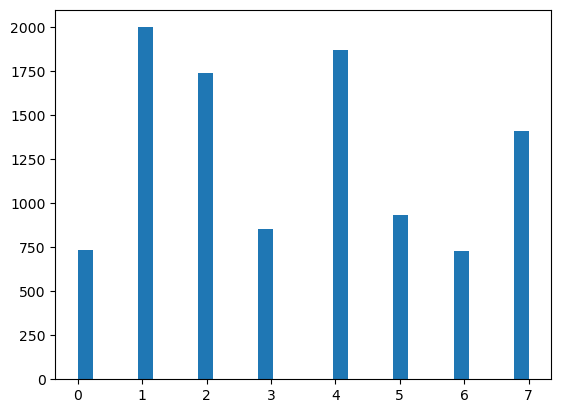

In [5]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(y_train, bins=30)
plt.show()

In [6]:
from sklearn.utils import resample

# Calculate the size of the smallest class
min_class_size = min(np.bincount(y_train))

# Undersampling majority classes to match the size of the minority class
X_train_balanced = []
y_train_balanced = []
for i in range(8):  # Assuming you have 8 classes
    X_class_i = X_train[y_train == i]
    y_class_i = y_train[y_train == i]
    X_class_i_resampled, y_class_i_resampled = resample(X_class_i, y_class_i, n_samples=min_class_size, random_state=42)
    X_train_balanced.append(X_class_i_resampled)
    y_train_balanced.append(y_class_i_resampled)

X_train_balanced = np.concatenate(X_train_balanced)
y_train_balanced = np.concatenate(y_train_balanced)

# #-------------------------
# # Oversampling minority classes to match the size of the majority class
# # You can use techniques like SMOTE for better synthetic sampling
# # Here, I'm just duplicating existing samples
# X_train_balanced_oversampled = []
# y_train_balanced_oversampled = []
# for i in range(8):  # Assuming you have 8 classes
#     X_class_i = X_train[y_train == i]
#     y_class_i = y_train[y_train == i]
#     X_class_i_oversampled, y_class_i_oversampled = resample(X_class_i, y_class_i, n_samples=len(X_train_balanced), random_state=42)
#     X_train_balanced_oversampled.append(X_class_i_oversampled)
#     y_train_balanced_oversampled.append(y_class_i_oversampled)

# X_train_balanced_oversampled = np.concatenate(X_train_balanced_oversampled)
# y_train_balanced_oversampled = np.concatenate(y_train_balanced_oversampled)


In [7]:
print(X_train_balanced.shape)
print(y_train_balanced.shape)
# print(y_train)


(5824, 30000)
(5824,)


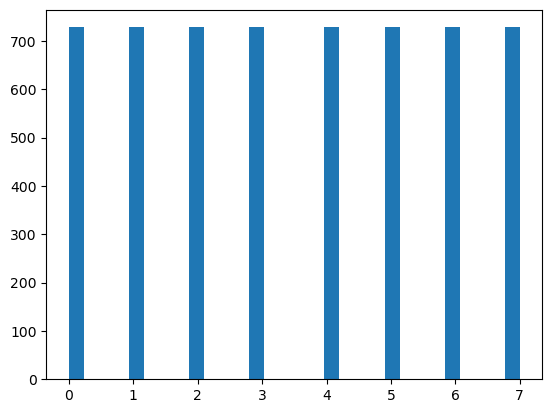

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(y_train_balanced, bins=30)
plt.show()

## Training the model (train the logistic regression)

Training/fiting the models

### VGG19

In [9]:
#import the base model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.applications import VGG19

# vgg_model = vgg19(
#     # weights='imagenet',
#     include_top=False,
#     input_shape=(100,100,3)
# )


vgg_model = VGG19(
    include_top=False,
    # weights='imagenet',
    # input_tensor=None,
    input_shape=(100,100,3),
    pooling=None,
    # classes=1000,
    # classifier_activation='softmax'
)


vgg_model.summary()

2024-04-12 07:39:28.115638: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-12 07:39:28.115669: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-12 07:39:28.115676: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-12 07:39:28.115773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-12 07:39:28.116015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [10]:
# Freeze all the layers in the base model
for layer in vgg_model.layers:
    layer.trainable = False

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow import keras

# Adding more layers
x = vgg_model.output
x = Flatten()(x) 
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(8, activation='softmax')(x)

#---------------
# Binding both 'models'
model = Model(inputs=vgg_model.input, 
              outputs=output)

#---------------

# Defining the optimizer, loss and metrics
# set_random_seed(121)
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3,
                           mode='min', 
                           verbose=1)


In [12]:
import tensorflow as tf
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# with tf.device('/device:GPU:0'):
    # model.fit(x_train, y_train)


In [14]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.4.1-arm64-arm-64bit
Tensor Flow Version: 2.13.0

Python 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:52:09) 
[Clang 14.0.6 ]
Pandas 2.0.3
Scikit-Learn 1.2.2
SciPy 1.10.1
GPU is available


In [17]:
from tensorflow.keras.utils import to_categorical

# Reshape flattened input data back to images
X_train_images = X_train_balanced.reshape(-1, 100, 100, 3)
X_test_images = X_test.reshape(-1, 100, 100, 3)

# y_train_balanced contains target labels
# Converting target labels to one-hot encoded format
y_train_encoded = to_categorical(y_train_balanced, num_classes=8)
y_test_encoded = to_categorical(y_test, num_classes=8)

In [17]:
# Training the model
history = model.fit(
    X_train_images,
    y_train_encoded,
          epochs=10,
    validation_data=(X_test_images, y_test_encoded),
          # callbacks=[early_stop]
         )

2024-04-11 15:33:50.081462: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
182/182 [==============================] - 176s 969ms/step - loss: 1.6969 - accuracy: 0.3156 - val_loss: 1.3115 - val_accuracy: 0.4604
Epoch 2/10
182/182 [==============================] - 178s 978ms/step - loss: 1.0805 - accuracy: 0.5896 - val_loss: 1.0698 - val_accuracy: 0.5934
Epoch 3/10
182/182 [==============================] - 184s 1s/step - loss: 0.8744 - accuracy: 0.6811 - val_loss: 0.9545 - val_accuracy: 0.6484
Epoch 4/10
182/182 [==============================] - 171s 943ms/step - loss: 0.7750 - accuracy: 0.7222 - val_loss: 0.8632 - val_accuracy: 0.6771
Epoch 5/10
182/182 [==============================] - 166s 914ms/step - loss: 0.7126 - accuracy: 0.7418 - val_loss: 0.8262 - val_accuracy: 0.6926
Epoch 6/10
182/182 [==============================] - 145s 799ms/step - loss: 0.6299 - accuracy: 0.7759 - val_loss: 0.7667 - val_accuracy: 0.7151
Epoch 7/10
182/182 [==============================] - 140s 768ms/step - loss: 0.5851 - accuracy: 0.7960 - val_loss: 0.7274 - va

In [18]:
# Evaluate the model's performance on the test data
# Accuracy
score = model.evaluate(X_test_images, y_test_encoded, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

107/107 [==============================] - 53s 496ms/step - loss: 0.6747 - accuracy: 0.7625
Test loss: 0.6746702790260315
Test accuracy: 0.7625036835670471


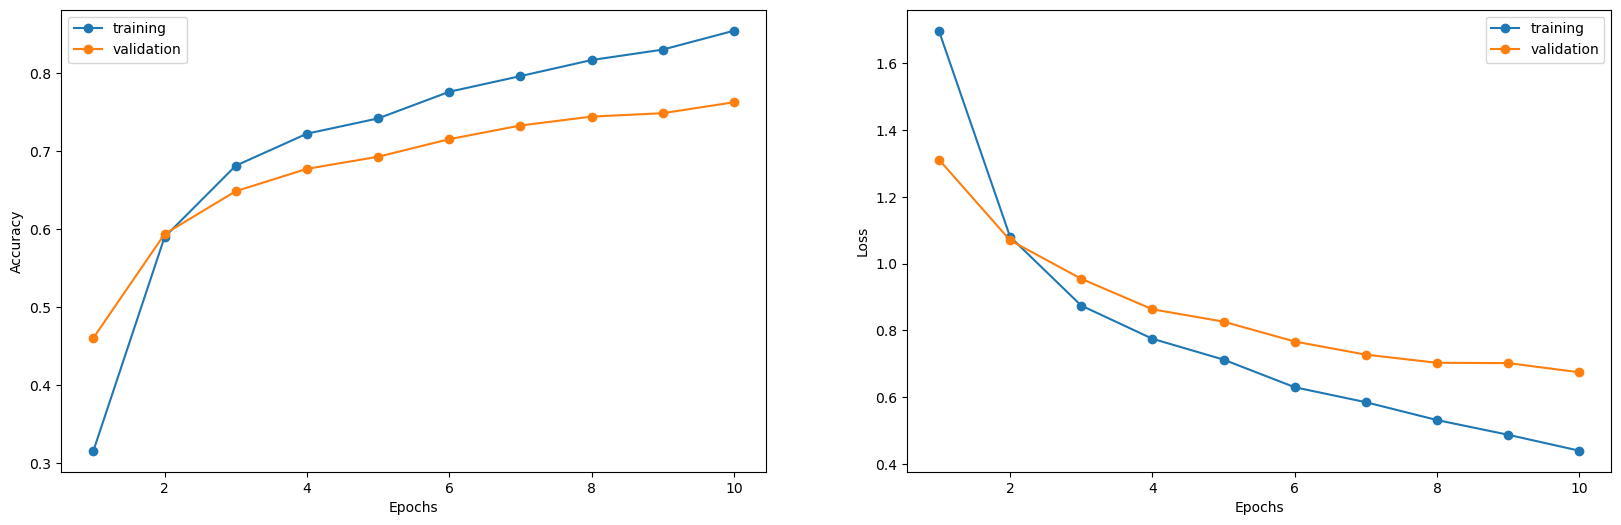

In [20]:
epochs = range(1, 11)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [32]:
# #Training with the best epochs

# # Training the model
with tf.device('/device:GPU:0'):
    history = model.fit(
        X_train_images,
        y_train_encoded,
              epochs=5,
        validation_data=(X_test_images, y_test_encoded),
              # callbacks=[early_stop]
             )

Epoch 1/5
182/182 [==============================] - 19s 107ms/step - loss: 0.8334 - accuracy: 0.6892 - val_loss: 0.8298 - val_accuracy: 0.6920
Epoch 2/5
182/182 [==============================] - 19s 105ms/step - loss: 0.7537 - accuracy: 0.7189 - val_loss: 0.8934 - val_accuracy: 0.6628
Epoch 3/5
182/182 [==============================] - 19s 104ms/step - loss: 0.6674 - accuracy: 0.7552 - val_loss: 0.8285 - val_accuracy: 0.6815
Epoch 4/5
182/182 [==============================] - 19s 103ms/step - loss: 0.5921 - accuracy: 0.7818 - val_loss: 0.7350 - val_accuracy: 0.7300
Epoch 5/5
182/182 [==============================] - 19s 103ms/step - loss: 0.5526 - accuracy: 0.7996 - val_loss: 0.7055 - val_accuracy: 0.7414


In [45]:
# # Checking the model's performance to ensure
score = model.evaluate(X_test_images, y_test_encoded, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

107/107 [==============================] - 7s 64ms/step - loss: 0.7055 - accuracy: 0.7414
Test loss: 0.7055248618125916
Test accuracy: 0.7414448857307434


## Evaluete the model

Seeing how the model peform with the train and test data:

### Accuracy, Precision, Recall, f1

Getting Accuracy, Precision, Recall and f1 from the model and seeing in each class

In [46]:
# Accuracy
score = model.evaluate(X_test_images, y_test_encoded, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

107/107 [==============================] - 7s 64ms/step - loss: 0.7055 - accuracy: 0.7414
Test loss: 0.7055248618125916
Test accuracy: 0.7414448857307434


In [47]:
# Predicting
y_score = model.predict(X_test_images)

107/107 [==============================] - 6s 56ms/step


In [48]:
# ONE-HOT ENCODE
# Convert probabilities to label encoding
y_predict = np.argmax(y_score, axis=1)

# Convert one-hot encoded labels to class labels for y_test
y_test_labels = np.argmax(y_test_encoded, axis=1)


In [49]:
# Sanity check on the encode
accuracy = accuracy_score(y_test_labels, y_predict)
print("Accuracy:", accuracy)

Accuracy: 0.7414448669201521


In [50]:
from sklearn.metrics import classification_report

# Generate classification report
report_initial = classification_report(y_test_labels, y_predict)
print(report_initial)

              precision    recall  f1-score   support

           0       0.81      0.62      0.70       243
           1       0.87      0.80      0.83       666
           2       0.56      0.74      0.63       579
           3       0.58      0.47      0.52       284
           4       0.80      0.71      0.75       624
           5       0.67      0.73      0.70       310
           6       0.71      0.86      0.78       243
           7       0.95      0.88      0.91       470

    accuracy                           0.74      3419
   macro avg       0.74      0.73      0.73      3419
weighted avg       0.76      0.74      0.74      3419



### Confusion Matrix 

Plotting the confusion Matrix (as a porcentage) and observate the classification from the model

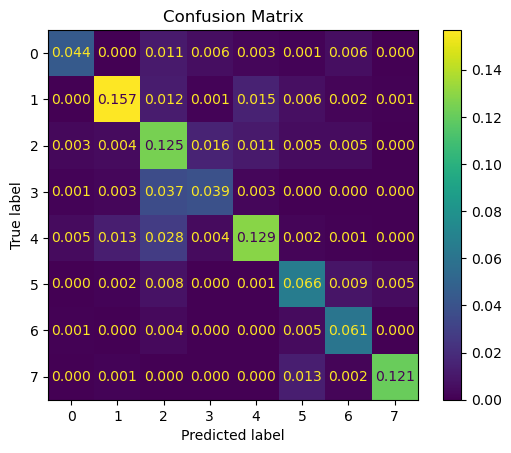

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_labels, y_predict, normalize='all', values_format='.3f')
plt.title('Confusion Matrix')
plt.show()


In [52]:
cells = {
    0 : 'basophil',
    1 : 'eosinophil',
    2 : 'erythroblast',
    3 : 'ig',
    4 : 'lymphocyte',
    5 : 'monocyte',
    6 : 'neutrophil',
    7 : 'platelet',
}

### ROC-AUC Evaluation

In [53]:

n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test_labels to a one-hot encoded format if it's not already in that format
if len(y_test_labels.shape) == 1:
    y_test_labels_one_hot = np.zeros((y_test_labels.size, y_test_labels.max() + 1))
    y_test_labels_one_hot[np.arange(y_test_labels.size), y_test_labels] = 1
else:
    y_test_labels_one_hot = y_test_labels

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_labels_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_labels_one_hot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score: {roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score: 0.96


In [54]:
# ROC curve using the OvR macro-average

n_classes = 8
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_labels_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

# ---------------------
# Can also evaluate with the build-in method, but for the next plot we need to have the variables
# macro_roc_auc_ovr = roc_auc_score(
#     y_test,
#     y_score,
#     multi_class="ovr",
#     average="macro",
# )
# print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")


Macro-averaged One-vs-Rest ROC AUC score:
0.96


NOTE : In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging. In such cases, one can alternatively use a weighted macro-averaging, not demoed here.

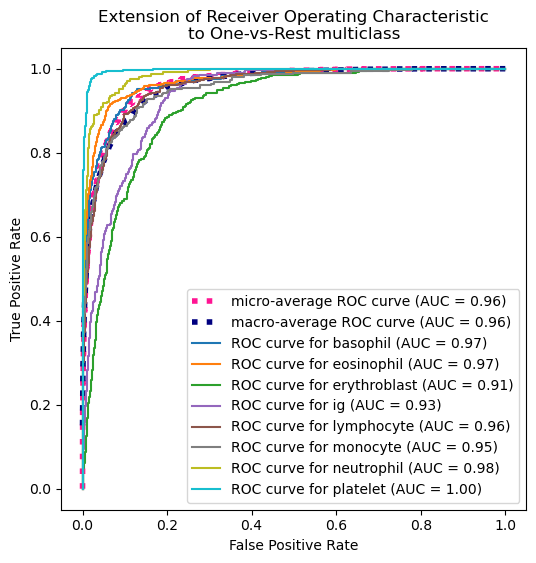

In [55]:
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

#Plotting micro-avg Roc curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Plotting Macro-AVG Roc curve
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

# Classes numbers
n_classes = 8

# Generate a color palette
colors = cycle(plt.cm.tab10(np.linspace(0, 1, n_classes)))

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test_labels_one_hot[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {cells[class_id]}",
        color=color,
        ax=ax,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

#reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## Using the model to predict the specifics images

In [56]:
# Load the model 

# logreg = joblib.load('../models/logistic_regression_model.pkl')
# result = logreg.score(X_test, y_test)
# print(result)

In [57]:
# filename = '../datasets/dataset_normal/basophil/BA_47.jpg'
# filename = '../datasets/dataset_normal/neutrophil/BNE_715.jpg'
filename = '../datasets/dataset_normal/neutrophil/BNE_840.jpg'

cells = {
    0 : 'basophil',
    1 : 'eosinophil',
    2 : 'erythroblast',
    3 : 'ig',
    4 : 'lymphocyte',
    5 : 'monocyte',
    6 : 'neutrophil',
    7 : 'platelet',
}

img = cv2.imread(os.path.join(filename))
img = cv2.resize(img, (100, 100))  # Resize image
image = img.flatten()  # Flatten image

result = model.predict(image)
print(np.argmax(result))

print(f"The cell that was detect was: {cells[np.argmax(result)]}")

ValueError: in user code:

    File "/Users/ottospigariol/anaconda3/envs/deeplearning/lib/python3.8/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Users/ottospigariol/anaconda3/envs/deeplearning/lib/python3.8/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ottospigariol/anaconda3/envs/deeplearning/lib/python3.8/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/ottospigariol/anaconda3/envs/deeplearning/lib/python3.8/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Users/ottospigariol/anaconda3/envs/deeplearning/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/ottospigariol/anaconda3/envs/deeplearning/lib/python3.8/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model' (type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'model' (type Functional):
      • inputs=tf.Tensor(shape=(None,), dtype=uint8)
      • training=False
      • mask=None


In [74]:
import cv2
import os
import numpy as np

# Assuming you have loaded the model already
# model = load_model('your_model_path')

# filename = '../datasets/dataset_normal/basophil/BA_47.jpg'
# filename = '../datasets/dataset_normal/neutrophil/BNE_715.jpg'
filename = '../datasets/dataset_normal/neutrophil/BNE_840.jpg'

cells = {
    0: 'basophil',
    1: 'eosinophil',
    2: 'erythroblast',
    3: 'ig',
    4: 'lymphocyte',
    5: 'monocyte',
    6: 'neutrophil',
    7: 'platelet',
}

# Load and preprocess the image
img = cv2.imread(os.path.join(filename))
img = cv2.resize(img, (100, 100))  # Resize image
img = img.astype('float32') / 255.0  # Normalize pixel values
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict
result = model.predict(img)
predicted_class = np.argmax(result)

print(f"The cell that was detected was: {cells[predicted_class]}")

The cell that was detected was: lymphocyte
